In [1]:
import glob
import pandas as pd
import gzip
import urllib.request
import codecs

from helpers import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/vecht499/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Get the data

From https://archive.org/download/amazon-reviews-1995-2013 we will download:
- gourmet foods
- pet supplies
- toys & games
- beauty
- health & personal care
- baby

Plus we will need all categories metadata

In [2]:
## It takes a while!
list_to_download = ['Gourmet_Foods','Pet_Supplies','Toys_&_Games','Beauty','Health','Baby','categories']

for i in list_to_download:
    if i in [x.split('data/')[1].split('.txt')[0] for x in glob.glob('../data/*')]:
        print("File {} is already downloaded".format(i))
    else:
        f = urllib.request.urlopen('https://archive.org/download/amazon-reviews-1995-2013/'+i+'.txt.gz')
        data = f.read()
        with open('../data/'+i+'.txt.gz', 'wb') as code:
            code.write(data)
            code.close()

        g = gzip.open('../data/'+i+'.txt.gz', 'rb')
        with open('../data/'+i+'.txt', 'wb') as outfile:
            for line in g:
                outfile.write(line)
            outfile.close()
        print("File {} is downloaded".format(i))

File Gourmet_Foods is already downloaded
File Pet_Supplies is already downloaded
File Toys_&_Games is downloaded
File Beauty is already downloaded
File Health is already downloaded
File Baby is already downloaded
File categories is already downloaded


In [3]:
df_list = []

for file in list_to_download[0:6]:
    
    with open('../data/'+file+'.txt', 'r') as f:
        reviews = f.read()
    
    reviews_list = reviews.split('\n\n')
    headers= ['productId','Title','userId','Helpfulness','Score','Text']

    all_records = []
    ## the last record is empty
    for i in range(len(reviews_list)-1):
        record = [reviews_list[i].split('\n')[0].split(': ')[1],
                  reviews_list[i].split('\n')[1].split(': ')[1],
                  reviews_list[i].split('\n')[3].split(': ')[1],
                  reviews_list[i].split('\n')[5].split(': ')[1],
                  reviews_list[i].split('\n')[6].split(': ')[1],
                  reviews_list[i].split('\n')[9].split(': ')[1]]
        all_records.append(record)
    
    df = pd.DataFrame(all_records, columns=headers)
    df_list.append(df)
    
df_reviews = pd.concat(df_list)

In [4]:
with codecs.open('../data/categories.txt', "r", "latin_1") as f:
    categories = f.read()
    
categories_list = categories.split('\n')
headers= ['productId','Cat1','Cat2','Cat3']

all_records = []
for i in range(len(categories_list)):
    if 'B00' in categories_list[i-1]:
        record = [categories_list[i-1]] + categories_list[i].split(", ")
        if len(record)<4:
            record = record+['Unknown']*(4-len(record))
        else:
            record = record[0:4]
        all_records.append(record) 
            
df_categories = pd.DataFrame(all_records, columns=headers)

In [5]:
df = df_reviews.merge(df_categories, on="productId", how='inner')

## Look at the data

In [6]:
df.head()

,productId,Title,userId,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,B000EVS4TY,"Arrowhead Mills Cookie Mix, Chocolate Chip, 12...",A2SRVDDDOQ8QJL,2/4,4.0,I thought it was funny that I bought this prod...,Grocery & Gourmet Food,Cooking & Baking Supplies,Baking Mixes
1,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,While in Hungary we were given a recipe for Hu...,Grocery & Gourmet Food,Herbs,Spices & Seasonings
2,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,"Without a doubt, I would recommend this wholes...",Grocery & Gourmet Food,Breakfast Foods,Cereals
3,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A12IDQSS4OW33B,3/3,5.0,This cereal is so sweet....yet so good for you...,Grocery & Gourmet Food,Breakfast Foods,Cereals
4,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A2GZKHC1M4PKF4,2/2,3.0,Man I love Oh's cereal. It is really great to ...,Grocery & Gourmet Food,Breakfast Foods,Cereals


In [7]:
len(df)

1672783

In [8]:
## drop duplicates
df = df.drop_duplicates().copy().reset_index(drop=True)
## remove nan reviews
df = df[pd.notnull(df.Text)].reset_index(drop=True).copy()

In [9]:
len(df)

1637755

In [10]:
df['Cat1'] = df['Cat1'].apply(lambda x: cleanData(x))
df['Cat2'] = df['Cat2'].apply(lambda x: cleanData(x))
df['Cat3'] = df['Cat3'].apply(lambda x: cleanData(x))

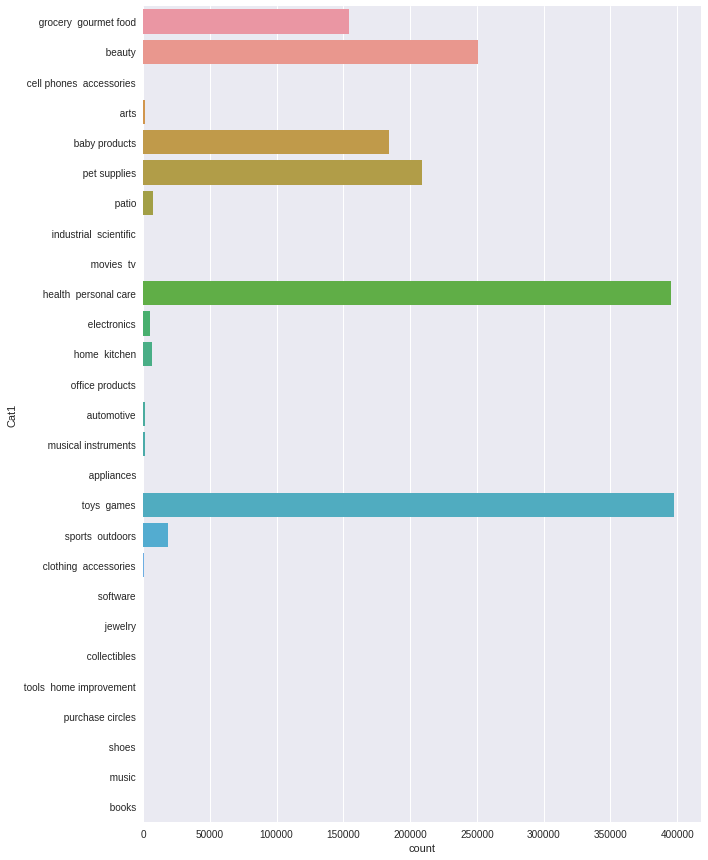

In [11]:
plt.figure(figsize=(10,15))
sns.countplot(y='Cat1', data=df)

## Modify dataset

In [26]:
len(df[(df.Cat1 == ' toys  games')|(df.Cat1 == ' health  personal care')|(df.Cat1 == ' pet supplies') \
       |(df.Cat1 == ' baby products') |(df.Cat1 == ' beauty')|(df.Cat1 == ' grocery  gourmet food')])

1591504

It makes sense to only take the categories which occur often. Also, we will put together categories such as **snack food** and **snack foods**, **candy**, **candy chocolate**, **chocolate** 

In [27]:
df_mod = df[(df.Cat1 == ' toys  games')|(df.Cat1 == ' health  personal care')|(df.Cat1 == ' pet supplies') \
            |(df.Cat1 == ' baby products') |(df.Cat1 == ' beauty')\
            |(df.Cat1 == ' grocery  gourmet food')].reset_index(drop=True).copy()

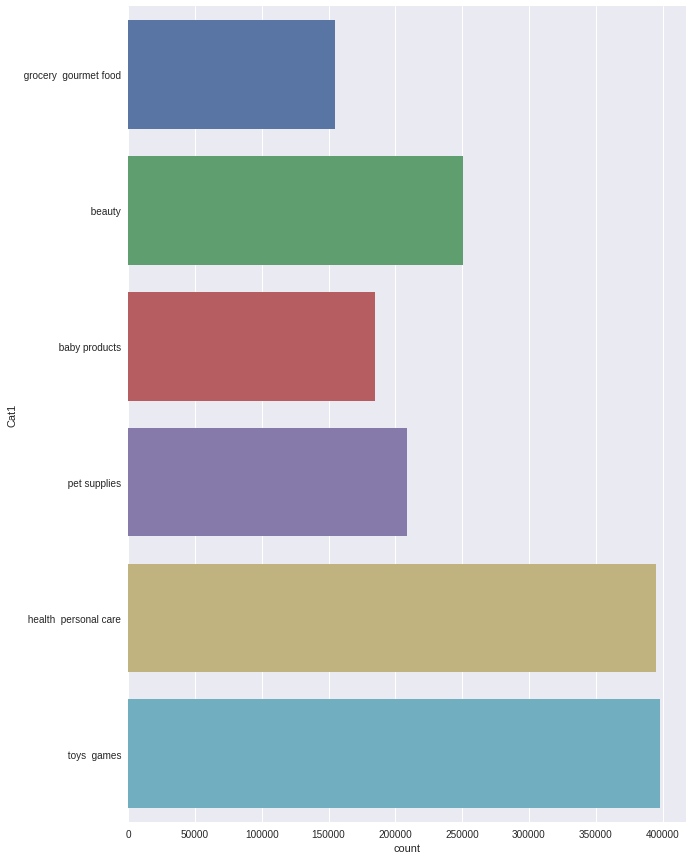

In [28]:
plt.figure(figsize=(10,15))
sns.countplot(y='Cat1', data=df_mod)

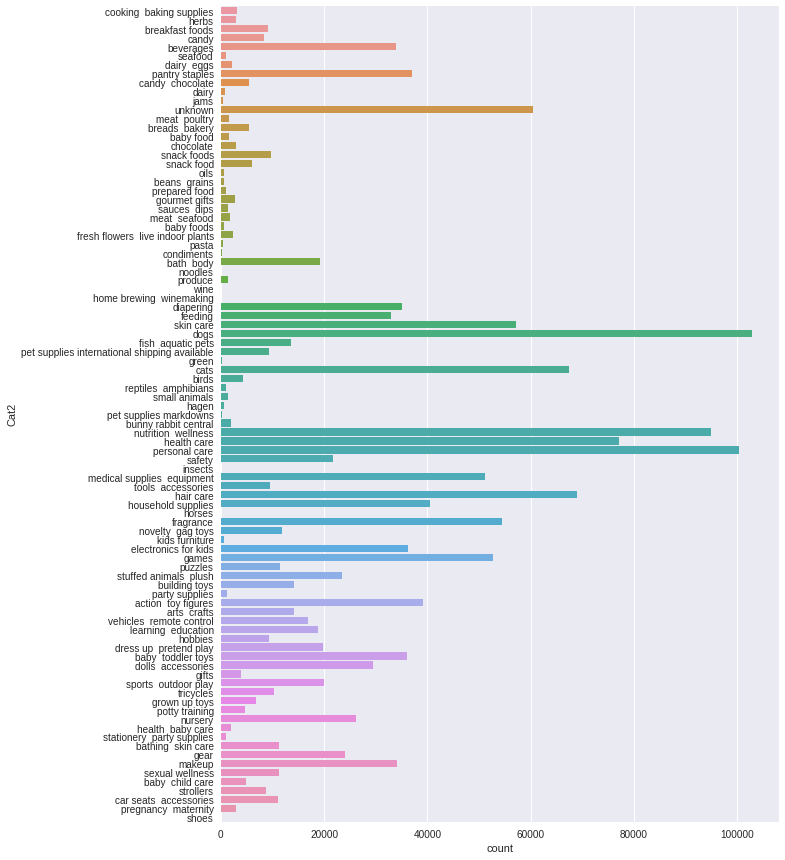

In [29]:
plt.figure(figsize=(10,15))
sns.countplot(y='Cat2', data=df_mod)

In [30]:
## put together some categories:
df_mod["Cat2"] = df_mod["Cat2"].apply(lambda x: 'candy chocolate' if x=='candy'
                                                 else 'candy chocolate' if x=='candy  chocolate'
                                                 else 'candy chocolate' if x=='chocolate'
                                                 else 'snack food' if x=='snack foods'
                                                 else x)

In [31]:
## remove Unknown
df_mod = df_mod[df_mod.Cat2 != 'unknown'].reset_index(drop=True).copy()

## remove pet supplies international shipping available
df_mod = df_mod[df_mod.Cat2 !='pet supplies international shipping available'].reset_index(drop=True).copy()

In [42]:
## remove products that occur only once
s = pd.DataFrame(df_mod.Title.value_counts())
df_mod = df_mod[df_mod.Title.isin(s[s.Title==1].index.tolist()) == False].reset_index(drop=True).copy()

## remove Cat2 that occur less than 1000 times
s = pd.DataFrame(df_mod.Cat2.value_counts())
df_mod = df_mod[df_mod.Cat2.isin(s[s.Cat2<1000].index.tolist()) == False].reset_index(drop=True).copy()

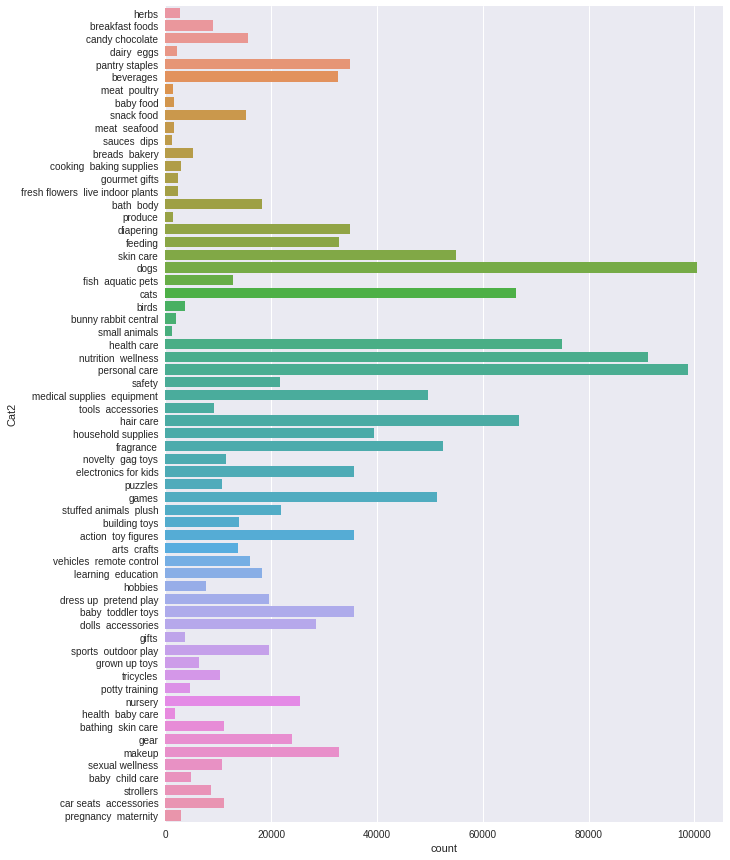

In [43]:
plt.figure(figsize=(10,15))
sns.countplot(y='Cat2', data=df_mod)

In [46]:
for i in df_mod.Cat1.unique().tolist():
    print(i, df_mod[df_mod.Cat1 == i].Cat2.unique())

 grocery  gourmet food ['herbs' 'breakfast foods' 'candy chocolate' 'dairy  eggs' 'pantry staples'
 'beverages' 'meat  poultry' 'baby food' 'snack food' 'meat  seafood'
 'sauces  dips' 'breads  bakery' 'cooking  baking supplies' 'gourmet gifts'
 'fresh flowers  live indoor plants' 'produce']
 beauty ['bath  body' 'skin care' 'tools  accessories' 'hair care' 'fragrance'
 'makeup']
 baby products ['diapering' 'feeding' 'safety' 'gifts' 'potty training' 'nursery'
 'health  baby care' 'bathing  skin care' 'gear' 'strollers'
 'car seats  accessories' 'pregnancy  maternity']
 pet supplies ['dogs' 'fish  aquatic pets' 'cats' 'birds' 'bunny rabbit central'
 'small animals']
 health  personal care ['health care' 'nutrition  wellness' 'personal care'
 'medical supplies  equipment' 'household supplies' 'sexual wellness'
 'baby  child care']
 toys  games ['novelty  gag toys' 'electronics for kids' 'puzzles' 'games'
 'stuffed animals  plush' 'building toys' 'action  toy figures'
 'arts  crafts' 've

In [47]:
len(df_mod)

1462161

In [48]:
df_mod.head()

,productId,Title,userId,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,While in Hungary we were given a recipe for Hu...,grocery gourmet food,herbs,spices seasonings
1,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,"Without a doubt, I would recommend this wholes...",grocery gourmet food,breakfast foods,cereals
2,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A12IDQSS4OW33B,3/3,5.0,This cereal is so sweet....yet so good for you...,grocery gourmet food,breakfast foods,cereals
3,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A2GZKHC1M4PKF4,2/2,3.0,Man I love Oh's cereal. It is really great to ...,grocery gourmet food,breakfast foods,cereals
4,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),AUGT2DOGKLHIN,2/2,5.0,And I've tried alot of cereals. This is by far...,grocery gourmet food,breakfast foods,cereals


In [49]:
df_mod.Title.value_counts()

Pampers Baby Dry Diapers (Packaging May Vary)                                                                                 10189
China Glaze Nail Lacquer with Hardeners                                                                                        5771
My Lip Stuff- Tube - Over 600 Lipbalm Flavors Available                                                                        5418
FURminator deShedding Tool                                                                                                     4728
Amazon.com                                                                                                                     4631
Pampers Cruisers Diapers                                                                                                       3568
Waterpik Ultra Water Flosser                                                                                                   3283
Omega Paw Self-Cleaning Litter Box, Green and Beige                         

## Save the dataset

In [50]:
df_mod.to_csv('../data/Reviews.csv', index=False)